# Importing TensorFlow

In [1]:
!nvidia-smi

Thu Jun 20 21:41:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P5             13W /   55W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-06-20 21:41:56.927982: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 21:41:56.950877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 21:41:56.950897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 21:41:56.951672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 21:41:56.956186: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import csv
import random
import tensorflow_hub as hub

# Preparing data

In [4]:
with open("./sentimet140_data/training_cleaned.csv", 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



In [5]:
sentences = []
labels = []
    
with open("./sentimet140_data/training_cleaned.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(0 if row[0] == 0 else 1)
        sentences.append(row[5])

In [6]:
print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


In [7]:
sentences_and_labels = list(zip(sentences, labels))

sentences_and_labels = random.sample(sentences_and_labels, 160000)
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



In [8]:
train_size = int(0.9*len(sentences))

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]
val_sentences = sentences[train_size:]
val_labels = labels[train_size:]

In [9]:
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


# Tokenization

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128345 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [11]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

train_pad_trunc_seq = tf.keras.utils.pad_sequences(train_sequences, padding="post", truncating="post", maxlen=16)
val_pad_trunc_seq = tf.keras.utils.pad_sequences(val_sequences, padding="post", truncating="post", maxlen=16)

In [12]:
print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
train_sentences = np.array(train_sentences)
val_sentences = np.array(val_sentences)

# Creating and training the model with pre-trained embedding layer

In [14]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [15]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

In [16]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

2024-06-20 21:42:02.807390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [17]:
pt_model = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [18]:
pt_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [19]:
pt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 lambda (Lambda)             (None, 512, 1)            0         
                                                                 
 dropout (Dropout)           (None, 512, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 508, 32)           192       
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                        

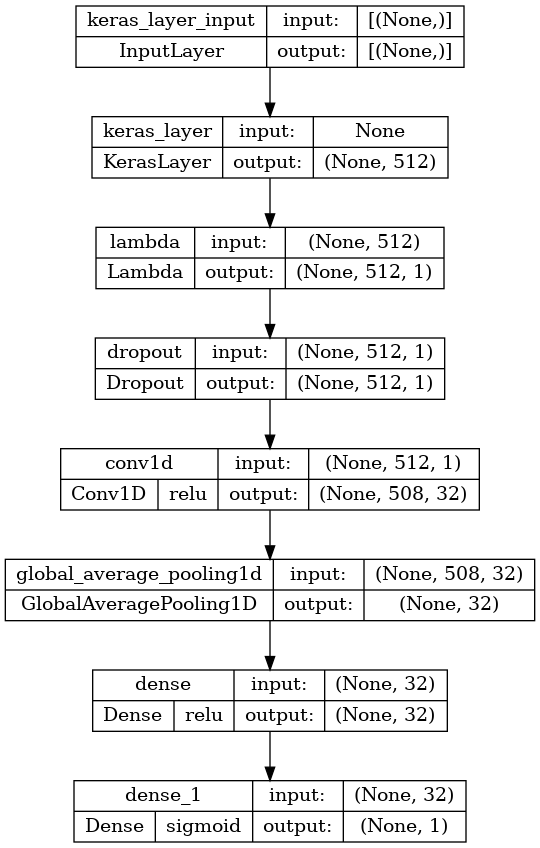

In [20]:
tf.keras.utils.plot_model(pt_model, show_layer_activations=True, show_shapes=True)

In [21]:
pt_history = pt_model.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 3,
    validation_data = (val_sentences, val_labels),
    callbacks = [model_checkpoint]
)

Epoch 1/3


2024-06-20 21:42:06.956206: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-20 21:42:08.264491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-20 21:42:08.305152: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-20 21:42:08.752138: I external/local_xla/xla/service/service.cc:168] XLA service 0x7472f4008490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-20 21:42:08.752157: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-20 21:42:08.755736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718908928.801841    9176 devic

4500/4500 [==============================] - 35s 7ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 2.3483e-04 - val_accuracy: 1.0000
Epoch 2/3
4500/4500 [==============================] - 28s 6ms/step - loss: 2.3486e-04 - accuracy: 1.0000 - val_loss: 2.3483e-04 - val_accuracy: 1.0000
Epoch 3/3
4500/4500 [==============================] - 29s 6ms/step - loss: 2.3486e-04 - accuracy: 1.0000 - val_loss: 2.3483e-04 - val_accuracy: 1.0000


<Axes: >

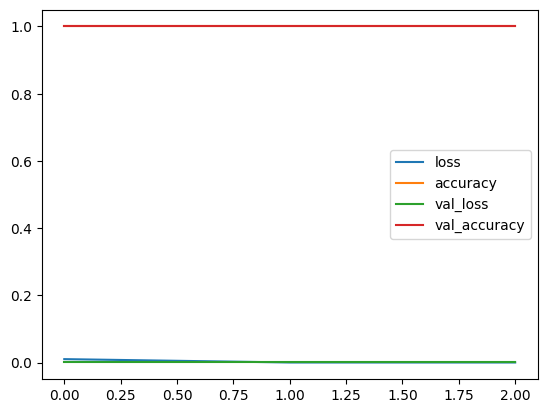

In [23]:
pd.DataFrame(pt_history.history).plot()

# Creating and training the model with not pre-trained embedding layer

In [24]:
npt_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(160001, 512, input_length=16),
    tf.keras.layers.Conv1D(32, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [25]:
npt_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [26]:
npt_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 512)           81920512  
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            81952     
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82006817 (312.83 MB)
Trainable params: 82006817 (312.83 MB)
Non-trainable params: 0 (0.00 Byte)
__________

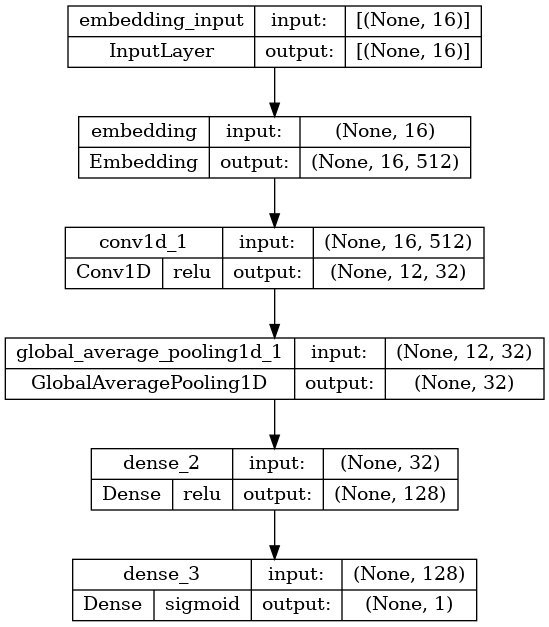

In [27]:
tf.keras.utils.plot_model(npt_model, show_layer_activations=True, show_shapes=True)

In [29]:
npt_history = npt_model.fit(
    x = train_pad_trunc_seq,
    y = train_labels,
    validation_data = (val_pad_trunc_seq, val_labels),
    epochs = 5,
    callbacks = [model_checkpoint]
)

Epoch 1/5
4500/4500 [==============================] - 120s 27ms/step - loss: 1.6142e-05 - accuracy: 1.0000 - val_loss: 4.0584e-05 - val_accuracy: 1.0000
Epoch 2/5
4500/4500 [==============================] - 119s 27ms/step - loss: 4.7286e-09 - accuracy: 1.0000 - val_loss: 4.0584e-05 - val_accuracy: 1.0000
Epoch 3/5
4500/4500 [==============================] - 119s 27ms/step - loss: 4.7154e-09 - accuracy: 1.0000 - val_loss: 4.0584e-05 - val_accuracy: 1.0000
Epoch 4/5
4500/4500 [==============================] - 119s 26ms/step - loss: 4.7154e-09 - accuracy: 1.0000 - val_loss: 4.0584e-05 - val_accuracy: 1.0000
Epoch 5/5
4500/4500 [==============================] - 120s 27ms/step - loss: 4.7154e-09 - accuracy: 1.0000 - val_loss: 4.0584e-05 - val_accuracy: 1.0000


<Axes: >

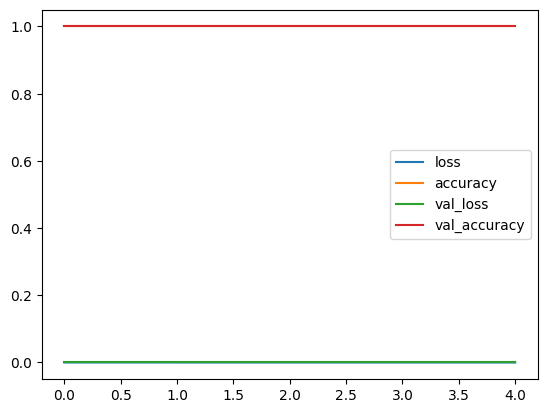

In [30]:
pd.DataFrame(npt_history.history).plot()

# Evaluation

In [31]:
pt_model.predict(val_sentences)

500/500 [==============================] - 2s 4ms/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float16)

In [33]:
npt_model.predict(val_pad_trunc_seq)

500/500 [==============================] - 0s 744us/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float16)

# Summary

Both models achieved 100% validation and training accuracy

npt_model is more faster when predicting

In [38]:
zeros = []
for eleman in val_labels:
    if eleman == 0:
        zeros.append(eleman)

In [39]:
zeros

[]